In [2]:
import os
import numpy as np
from typing import List, Callable, Tuple
from matplotlib import pyplot as plt
from pyimzml.ImzMLParser import (ImzMLParser, _bisect_spectrum)
from skimage import (filters, io, transform, color)

# Hellper functions:

In [3]:
def get_ion_image(p: ImzMLParser,
                  mz_values: List[float],
                  tol: float = 0.1,
                  z: int = 1,
                  reduce_func: Callable = sum) -> np.ndarray:
    """
    Get an image representation of the intensity distribution
    of the ion with specified m/z values.

    By default, the intensity values within the tolerance region are summed.

    Args:
        p (ImzMLParser): the ImzMLParser (or anything else with similar
        attributes) for the desired dataset.
        mz_values (List[float]): m/z values for which the ion image
        shall be returned
        tol (float, optional): Absolute tolerance for the m/z value,
        such that all ions with values mz_value-|tol| <= x <= mz_value+|tol|
        are included. Defaults to 0.1
        z (int, optional): z Value if spectrogram is 3-dimensional.
        Defaults to 1.
        reduce_func (Callable, optional): the bahaviour for reducing the
        intensities between mz_value-|tol| and mz_value+|tol| to a single
        value. Must be a function that takes a sequence as input and outputs
        a number. By default, the values are summed. Defaults to sum.

    Returns:
        [np.ndarray]: numpy matrix with each element representing the
        ion intensity in this pixel. Can be easily plotted with matplotlib

    """
    tol = abs(tol)
    max_y = p.imzmldict["max count of pixels y"]
    max_x = p.imzmldict["max count of pixels x"]
    ims = [np.zeros((max_y, max_x)) for _ in range(0, len(mz_values))]
    for i, (x, y, z_) in enumerate(p.coordinates):
      if z_ == 0:
        UserWarning(("z coordinate = 0 present, if you're getting blank "
                     "images set getionimage(.., .., z=0)"))
      if z_ == z:
        mzs, ints = map(np.asarray, p.getspectrum(i))
        for j, mz_value in enumerate(mz_values):
          im = ims[j]
          min_i, max_i = _bisect_spectrum(mzs, mz_value, tol)
          im[y - 1, x - 1] = reduce_func(ints[min_i:max_i + 1])
    return ims

In [4]:
def try_all_threshold(img: np.ndarray, figsize: Tuple[int, int], blur:bool):
  # create subplot
  fig, axes = plt.subplots(ncols=8, sharex=True, sharey=True,
                           figsize=figsize)
  
  # apply gaussian blur to image
  if blur:
    smooth = filters.gaussian(img, sigma=1.5)
  else:
    smooth = img
  
  
  # threshold
  thresh_isodata = filters.threshold_isodata(smooth)
  thresh_li = filters.threshold_li(smooth)
  thresh_mean = filters.threshold_mean(smooth)
  thresh_min = filters.threshold_minimum(smooth)
  thresh_otsu = filters.threshold_otsu(smooth)
  thresh_triangle = filters.threshold_triangle(smooth)
  thresh_yen = filters.threshold_yen(smooth)
  
  # add each subplot
  axes[0].imshow(img, cmap=plt.cm.gray)
  axes[0].set_title('Original')
  
  axes[1].imshow(smooth > thresh_isodata, cmap=plt.cm.gray)
  axes[1].set_title('Isodata')

  axes[2].imshow(smooth > thresh_li, cmap=plt.cm.gray)
  axes[2].set_title('Li')
  
  axes[3].imshow(smooth > thresh_mean, cmap=plt.cm.gray)
  axes[3].set_title('Mean')
  
  axes[4].imshow(smooth > thresh_min, cmap=plt.cm.gray)
  axes[4].set_title('Minimum')
  
  axes[5].imshow(smooth > thresh_otsu, cmap=plt.cm.gray)
  axes[5].set_title('Otsu')
  
  axes[6].imshow(smooth > thresh_triangle, cmap=plt.cm.gray)
  axes[6].set_title('Triangle')
  
  axes[7].imshow(smooth > thresh_yen, cmap=plt.cm.gray)
  axes[7].set_title('Yen')

  # remove axis from each subplot
  for ax in axes:
      ax.axis('off')
  
  # return plot
  return fig, axes

# Global Variables:

In [7]:
# set path containing the MSI dataset
msi_data_p = "/sise/assafzar-group/assafzar/Leor/DHG/Cropped/TIC-normalized/"

# set path containing the DHG H&E images
he_data_p = "/sise/assafzar-group/assafzar/Leor/DHG/H&E/"

# define the m/z values we wish to visualize
plot_mz = [749.5, 834.5, 888.6]
# define the tolerance for retrieving an m/z value
plot_tol = 0.025
# define plot full brithness percenbtage treshould
plot_tresh = 75

# MSI Thresholding:

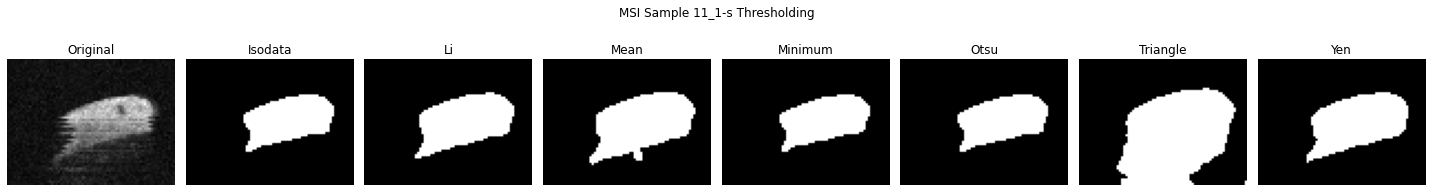

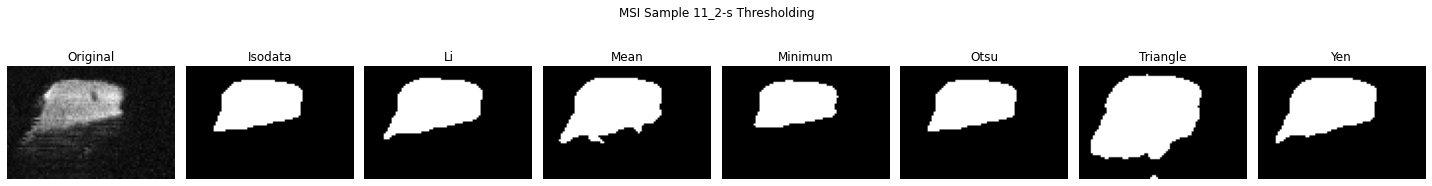

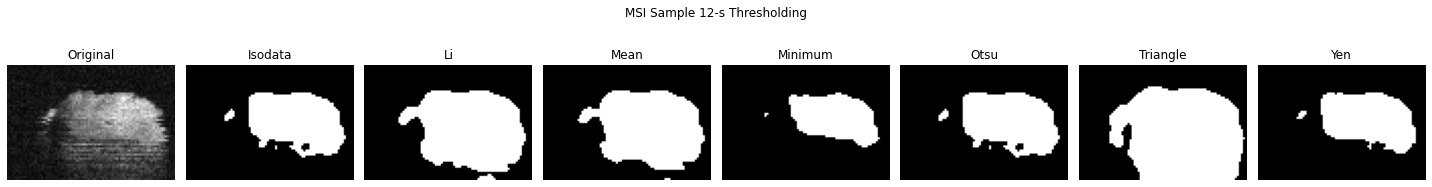

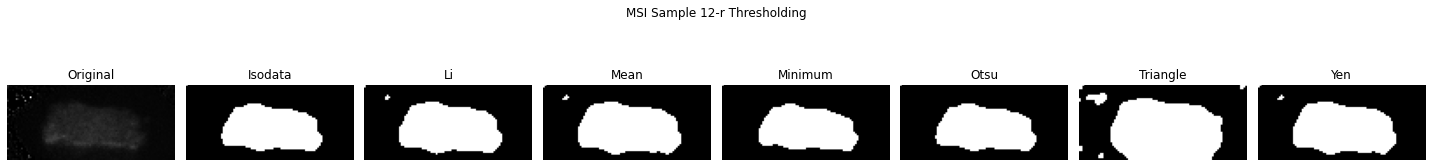

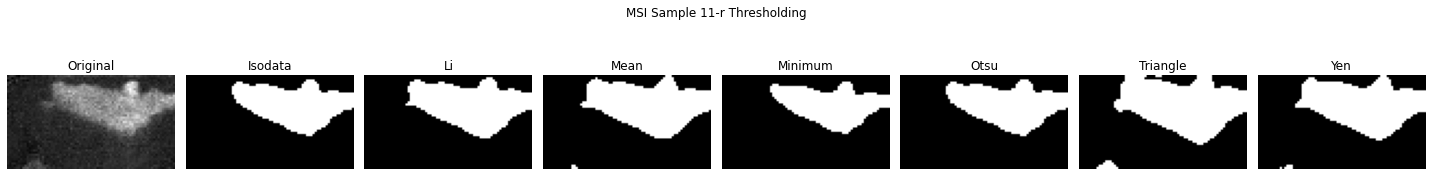

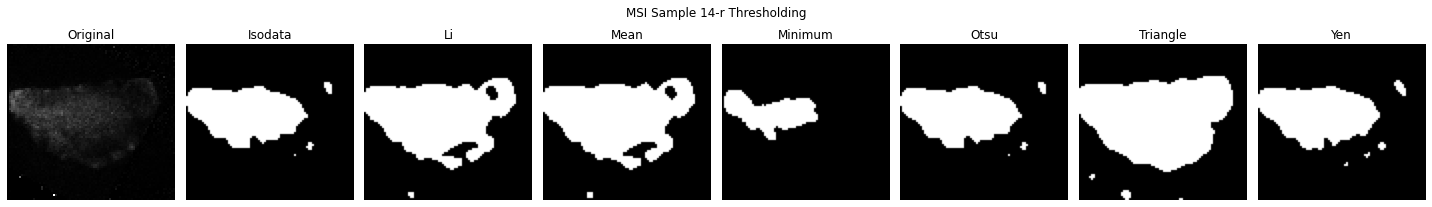

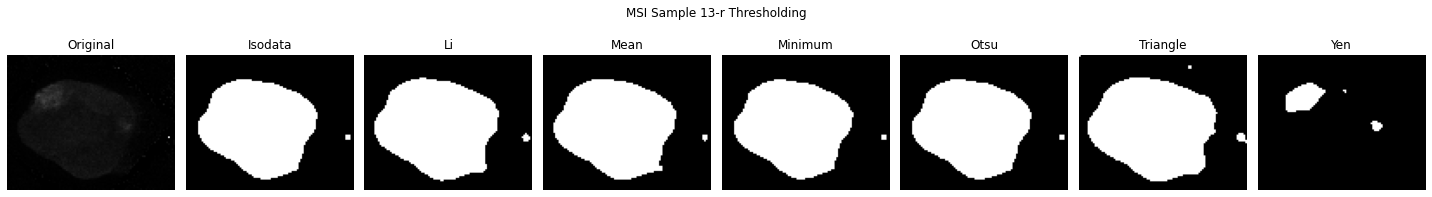

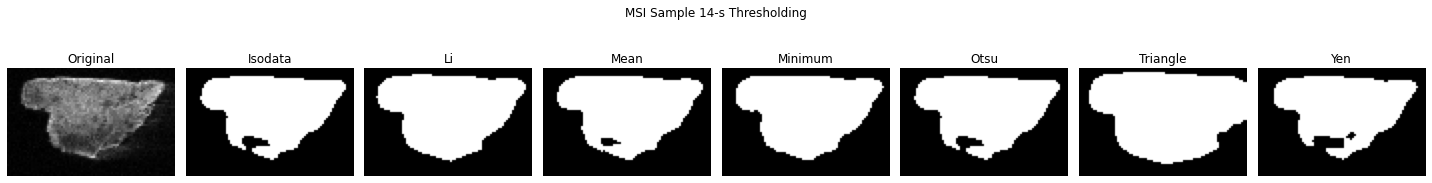

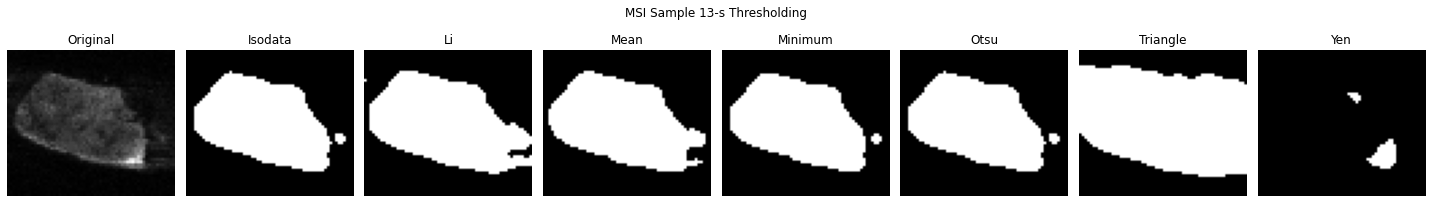

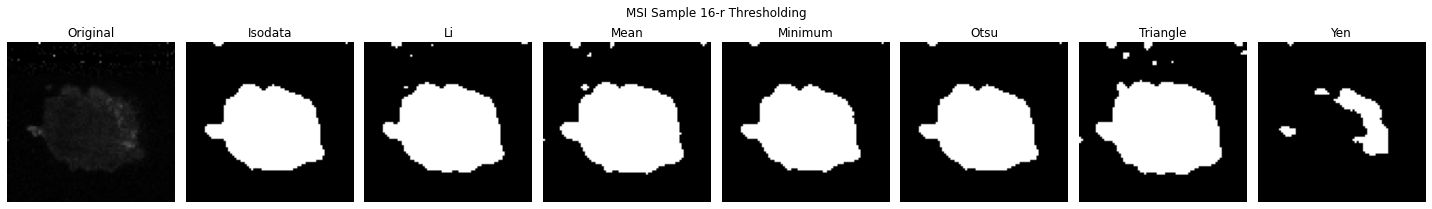

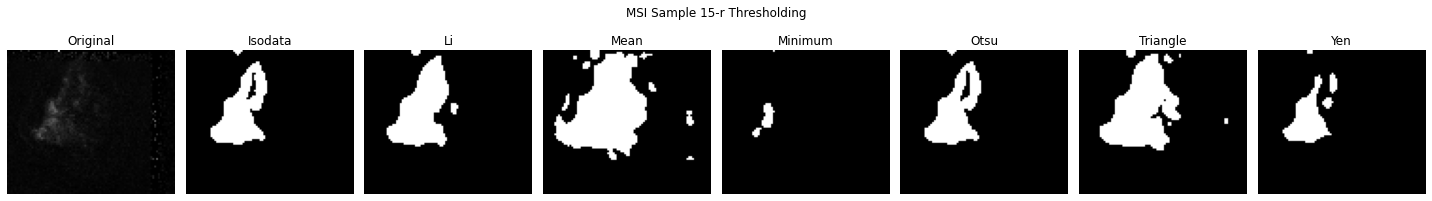

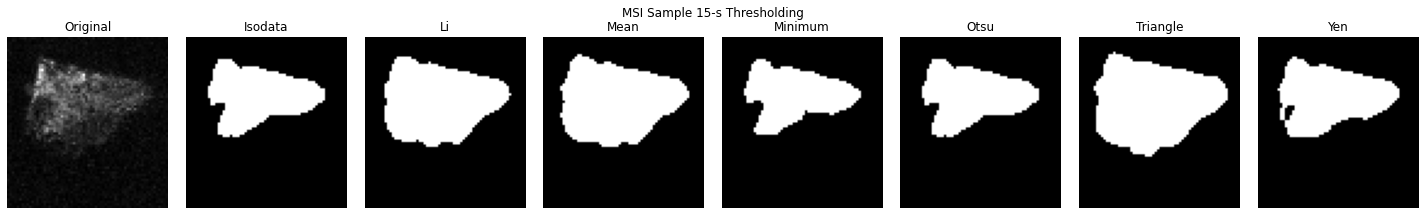

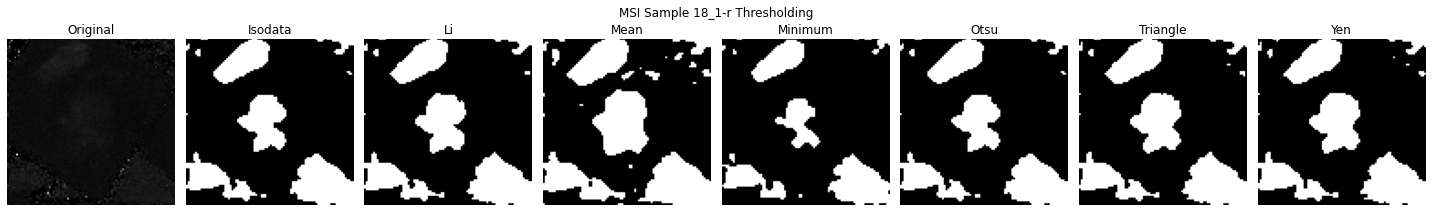

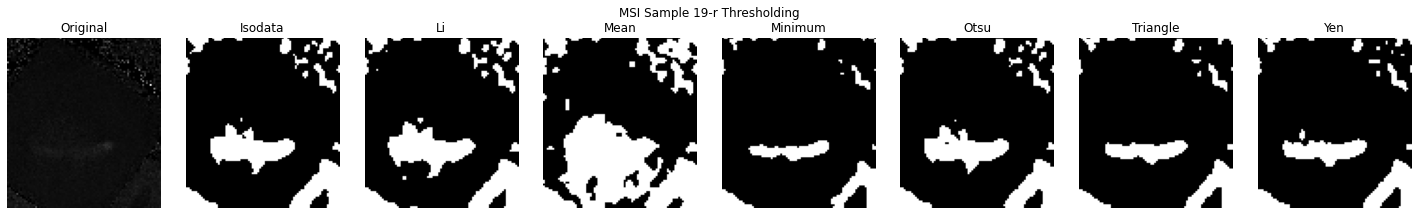

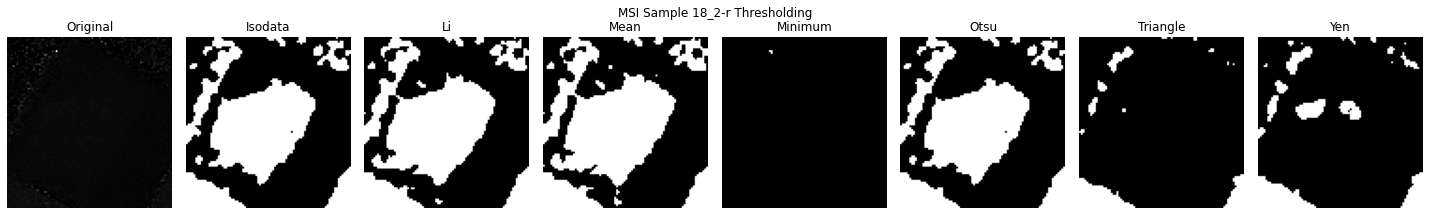

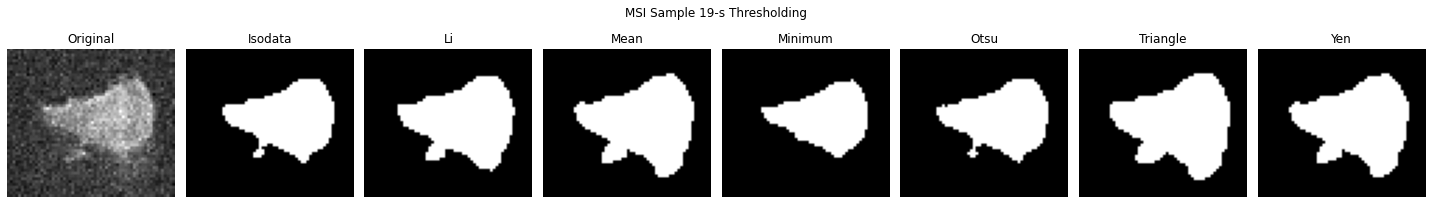

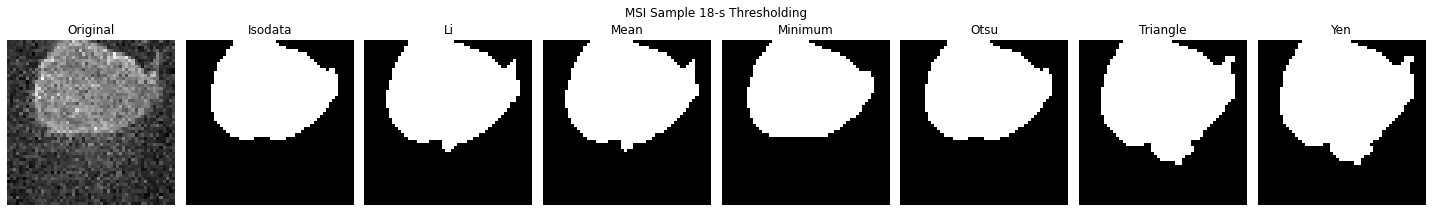

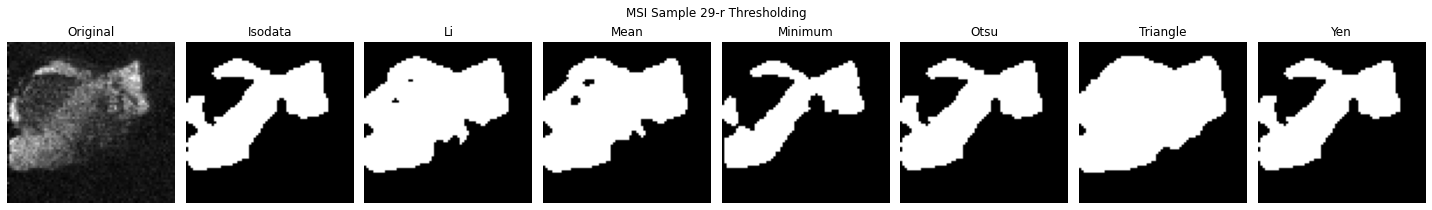

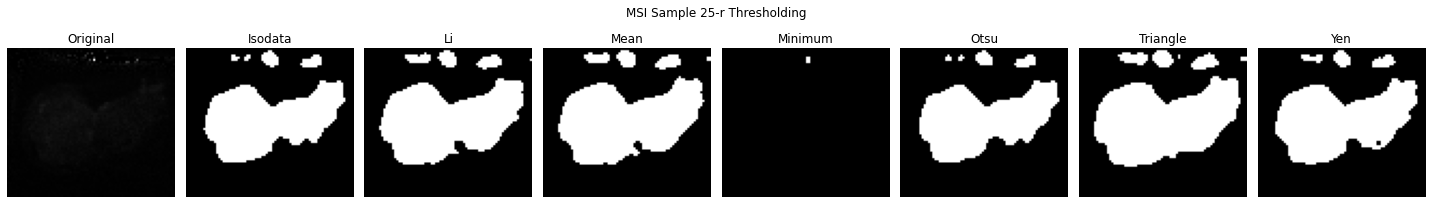

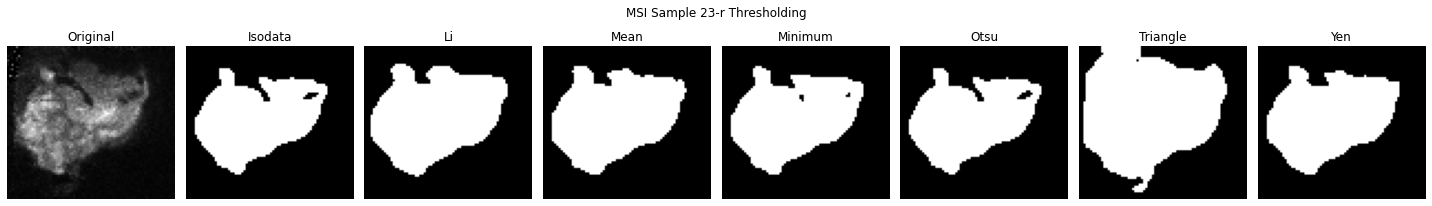

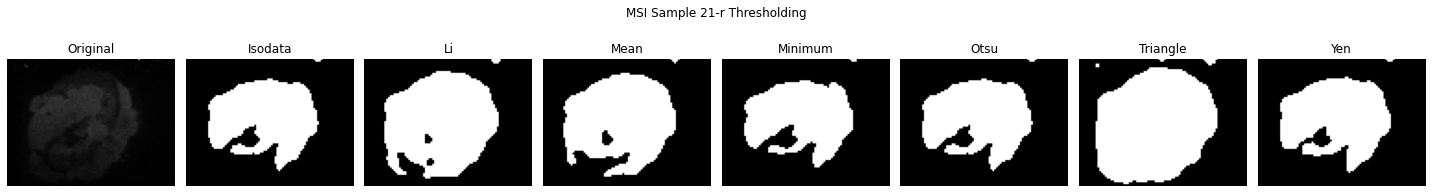

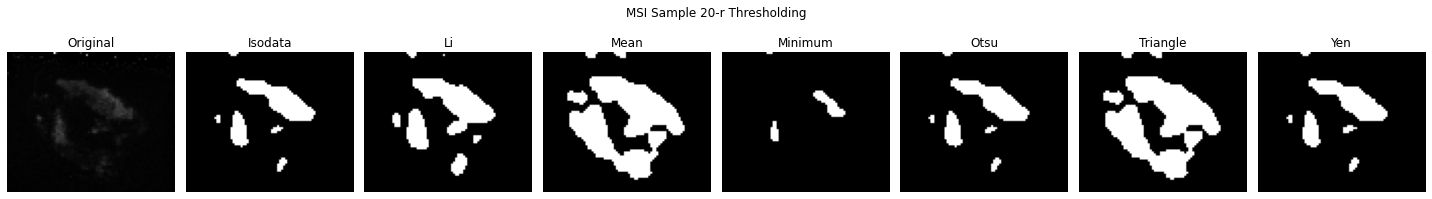

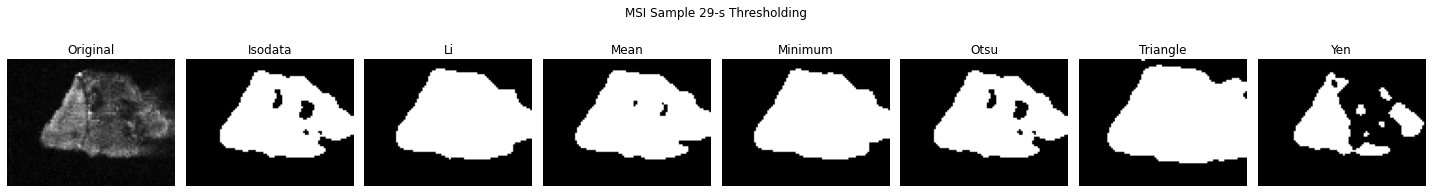

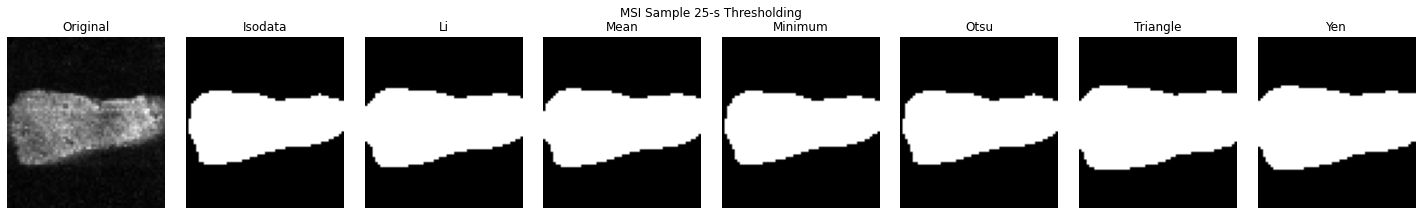

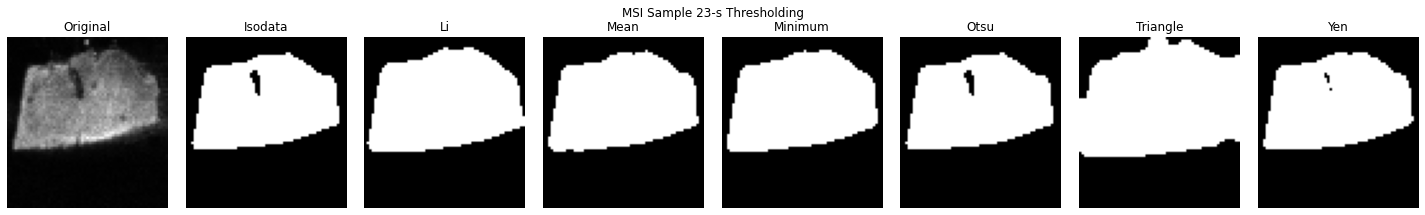

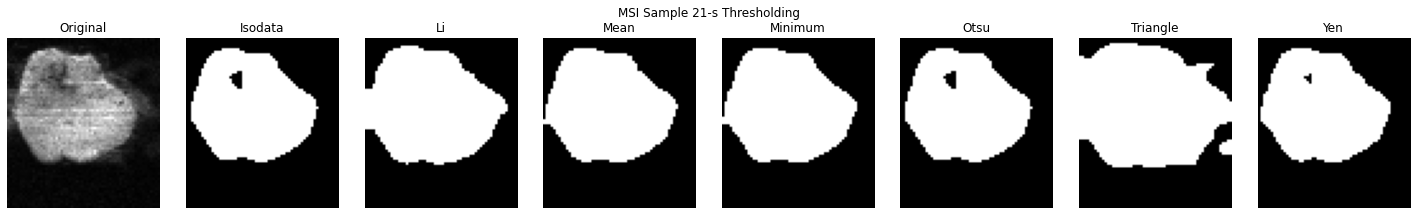

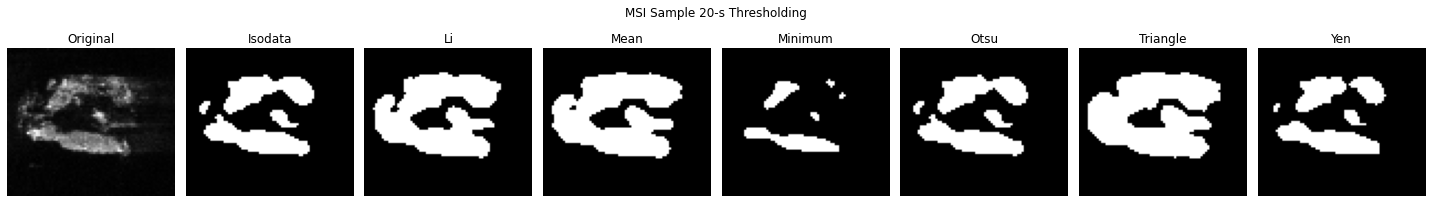

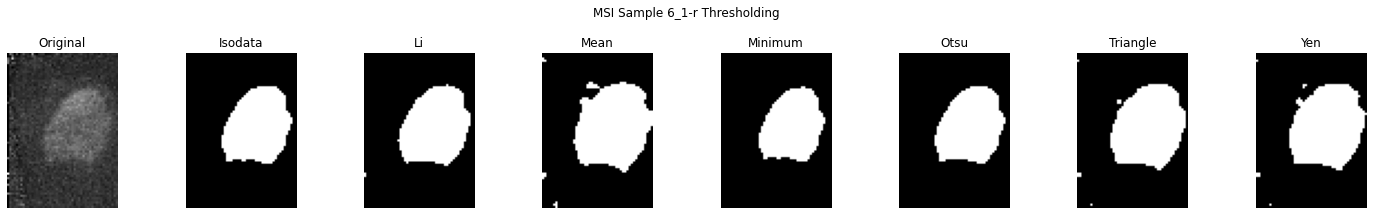

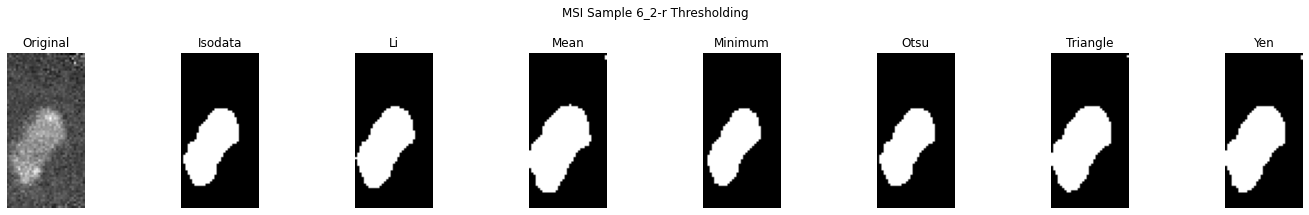

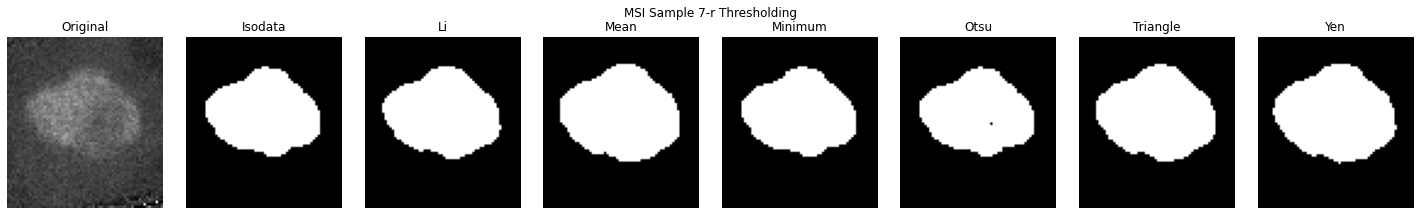

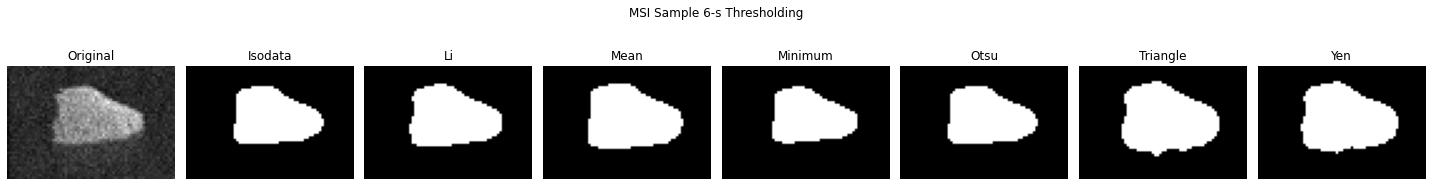

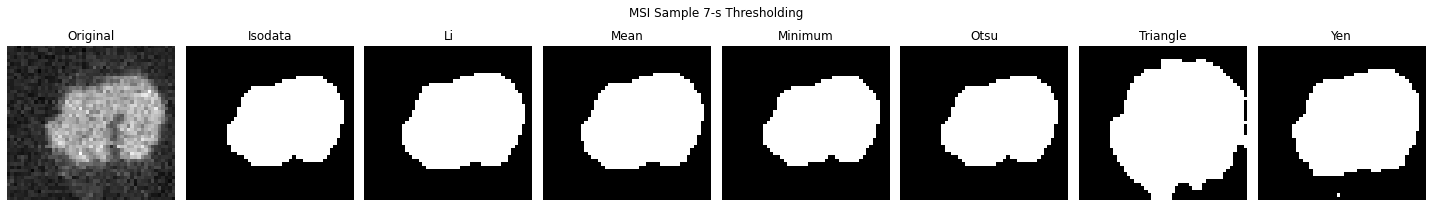

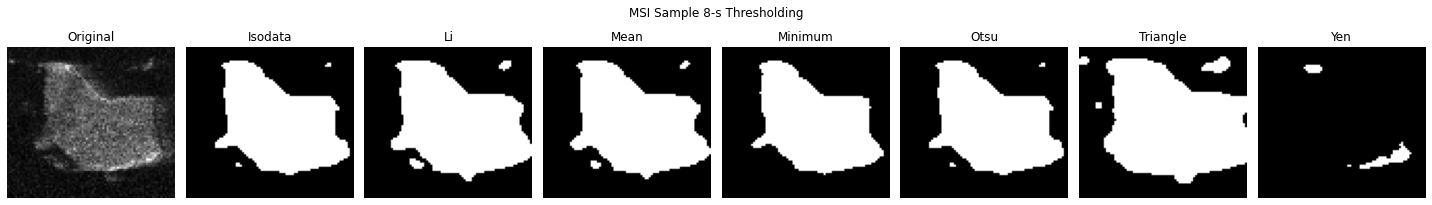

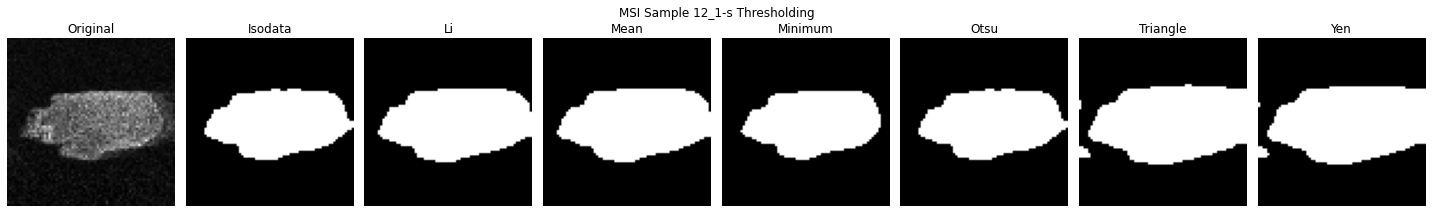

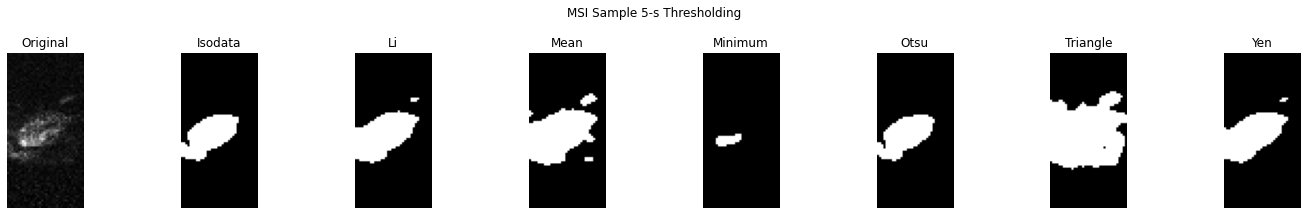

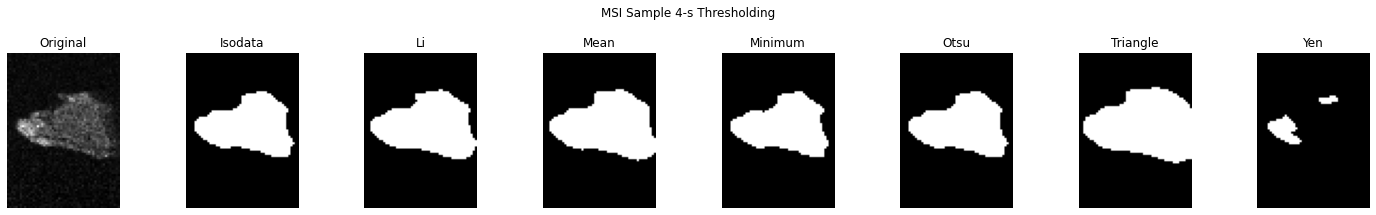

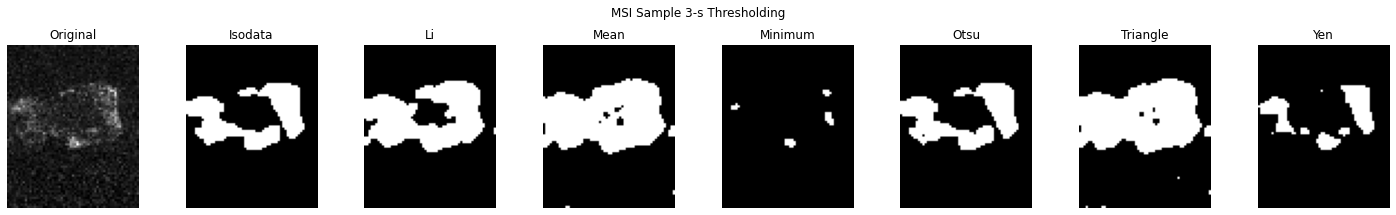

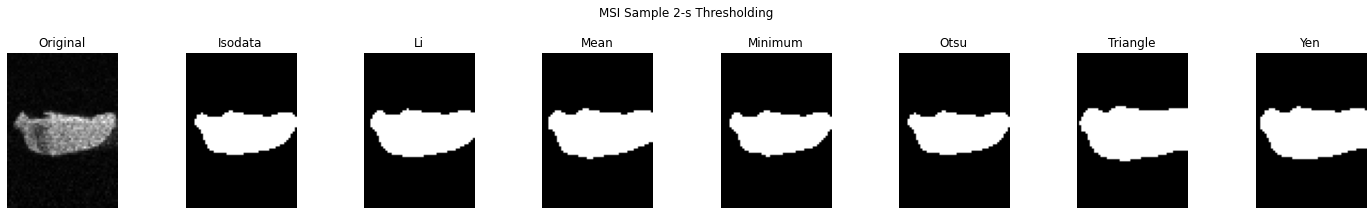

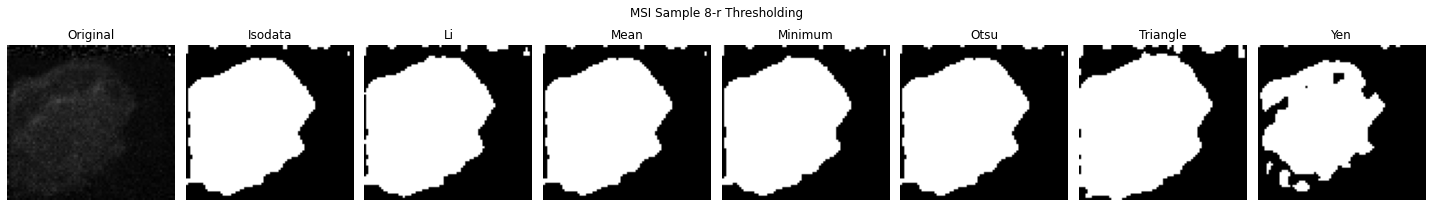

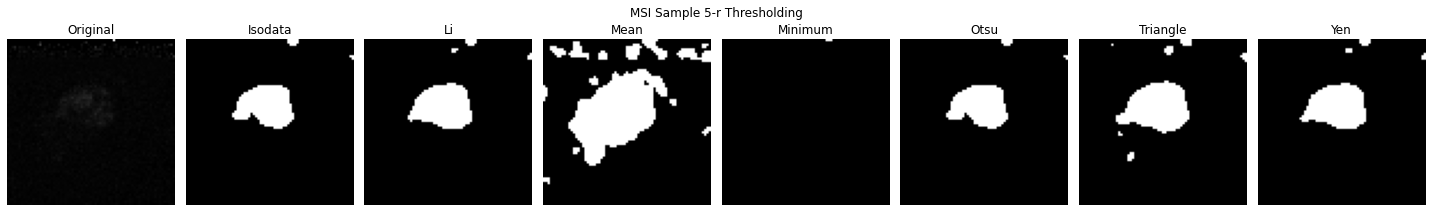

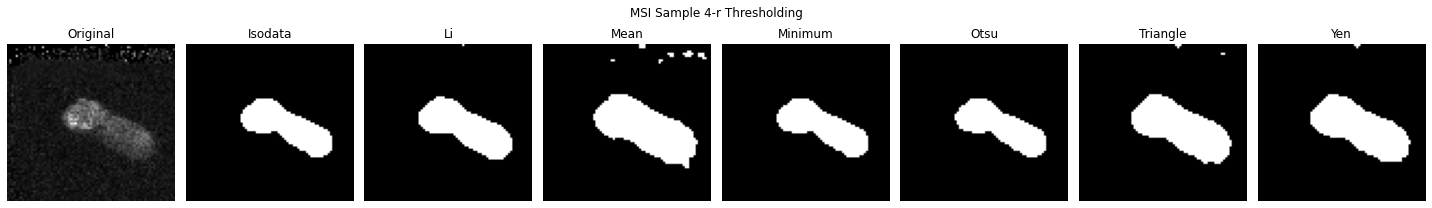

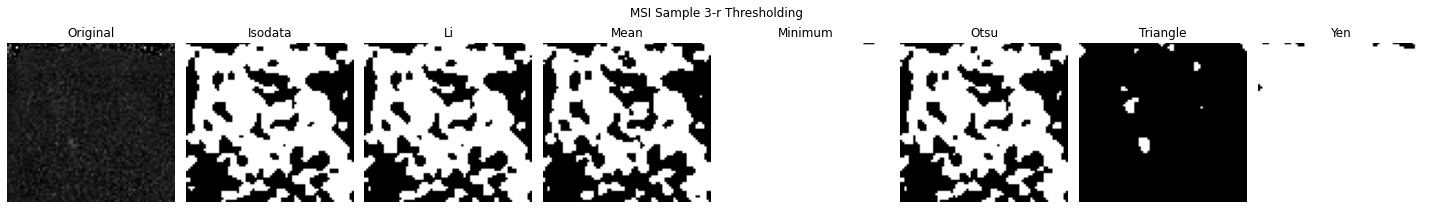

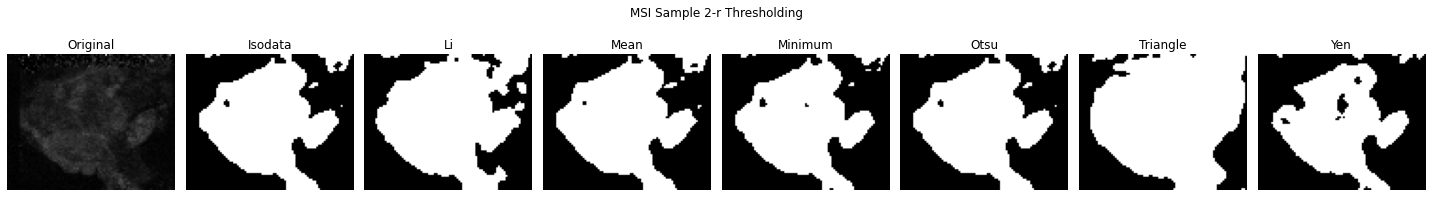

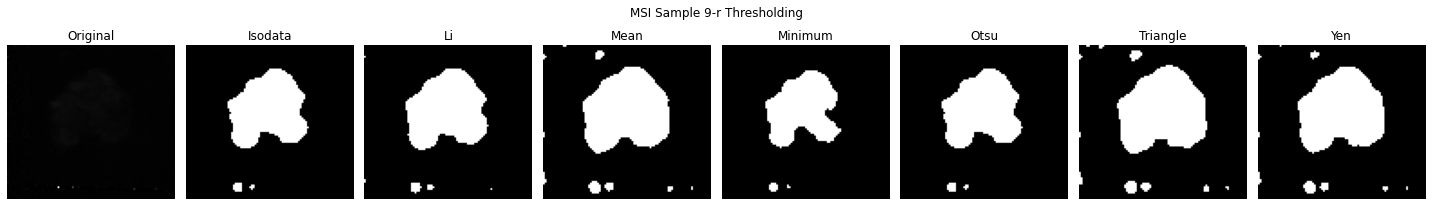

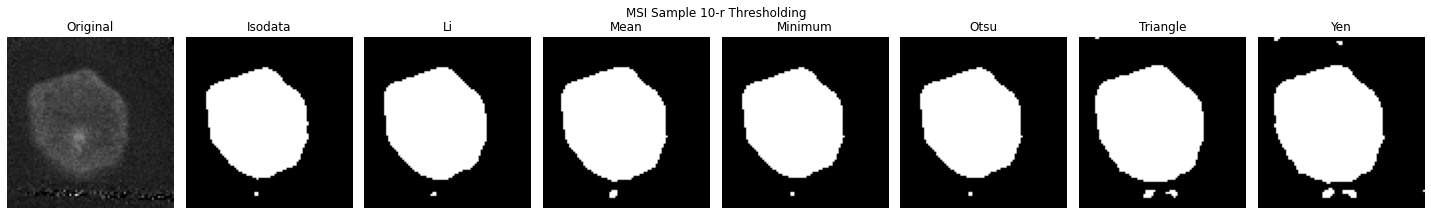

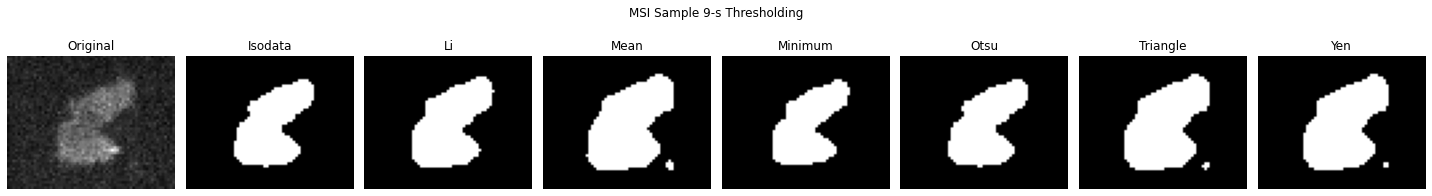

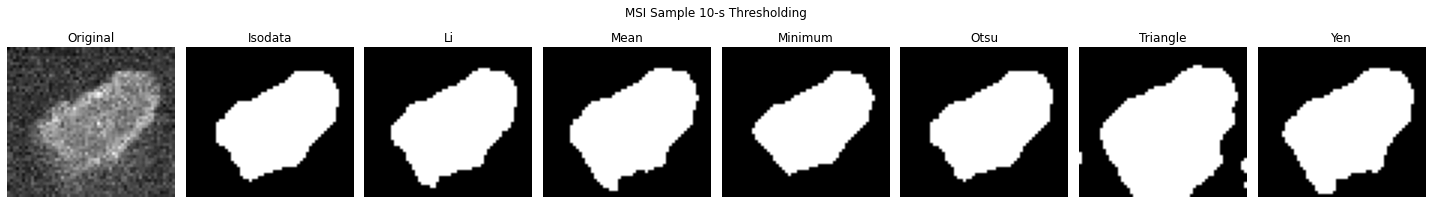

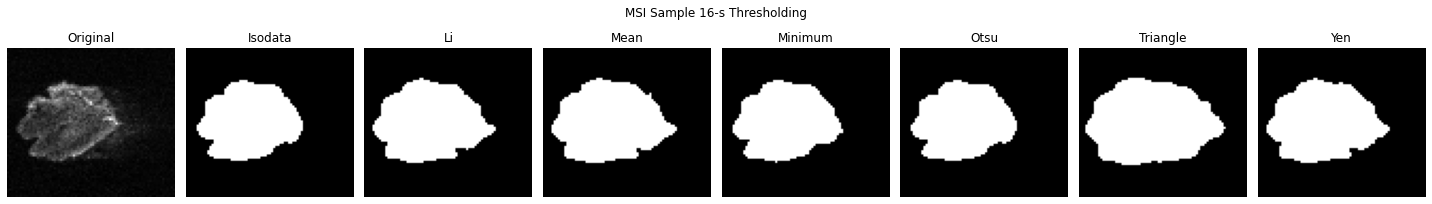

In [8]:
# get all mass spec images names
msi_names = np.asarray([f for f in os.listdir(msi_data_p) if f.endswith('.imzML')])

# loop over each mass spec image name and plot mz ion image
for msi_name in msi_names:
  # Parse the mass spec image imzML file
  with ImzMLParser(os.path.join(msi_data_p, msi_name)) as p_l:
    # Get ion image representation for each m/z value
    mz_imgs = get_ion_image(p_l, plot_mz, tol=plot_tol)
    
    # Create sum image of all m/z values
    msi_img = sum(mz_imgs)
    
    # get all thresholding algorithms outputs
    fig, ax = try_all_threshold(msi_img, figsize=(20, 3), blur=True)

    # plot thresholding algorithms outputs
    fig.suptitle(f"MSI Sample {msi_name.split('.')[0]} Thresholding")
    plt.tight_layout()
    plt.show()

# H&E Thresholding:

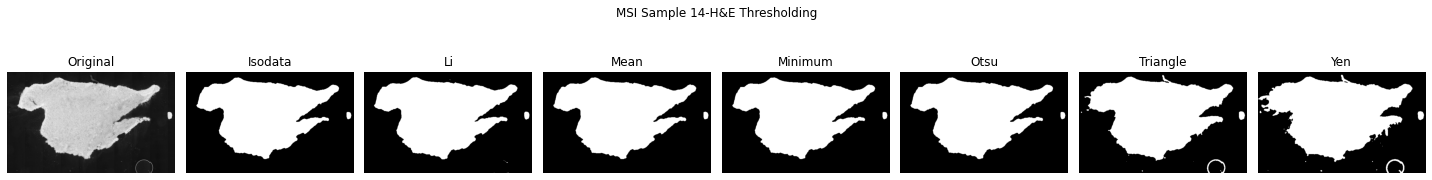

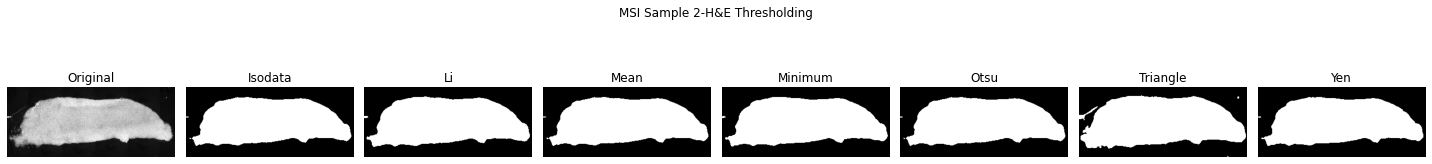

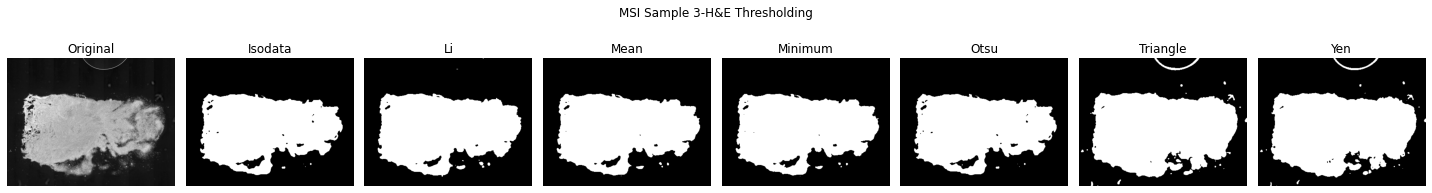

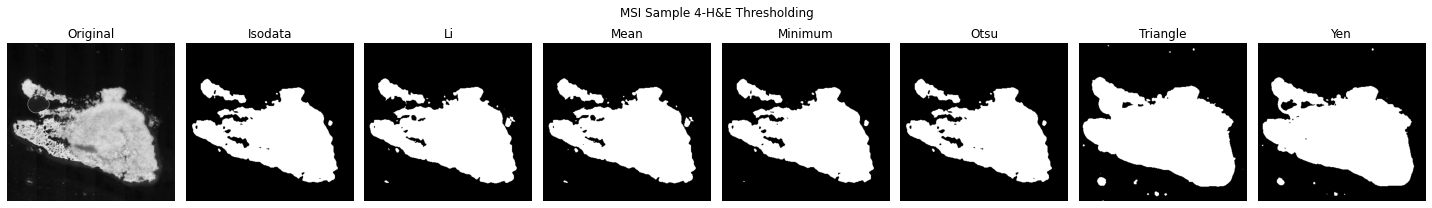

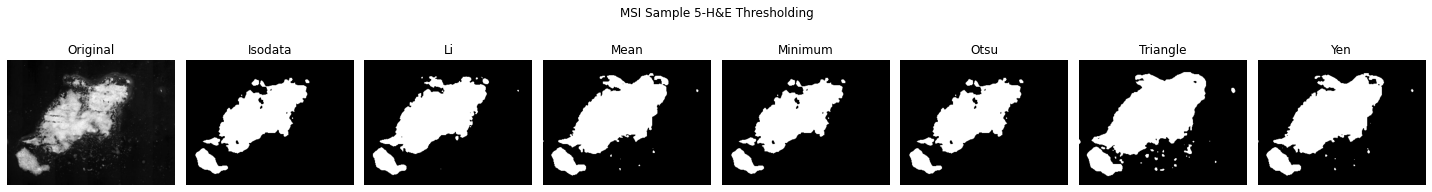

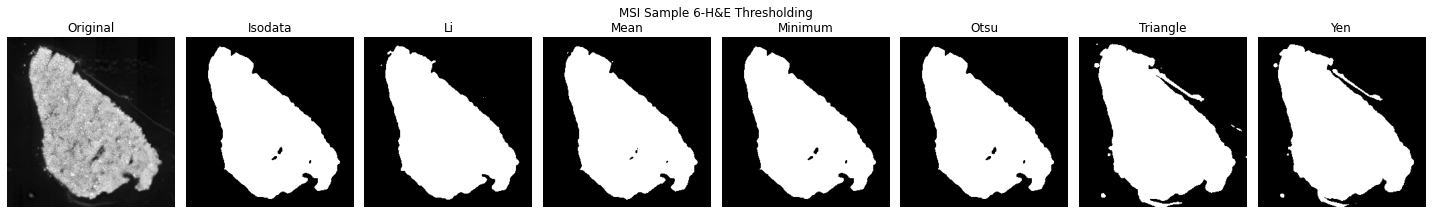

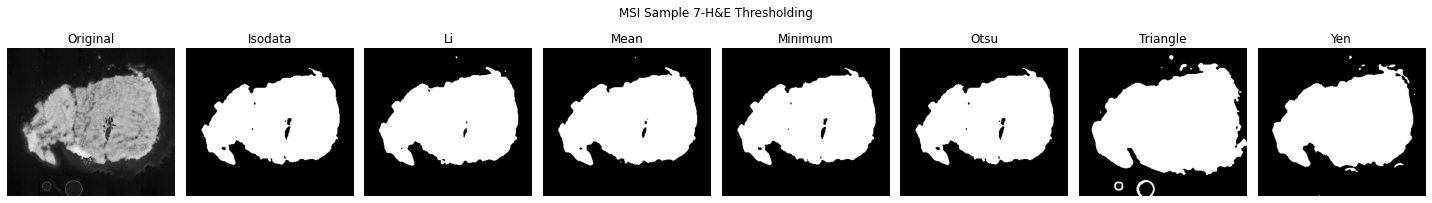

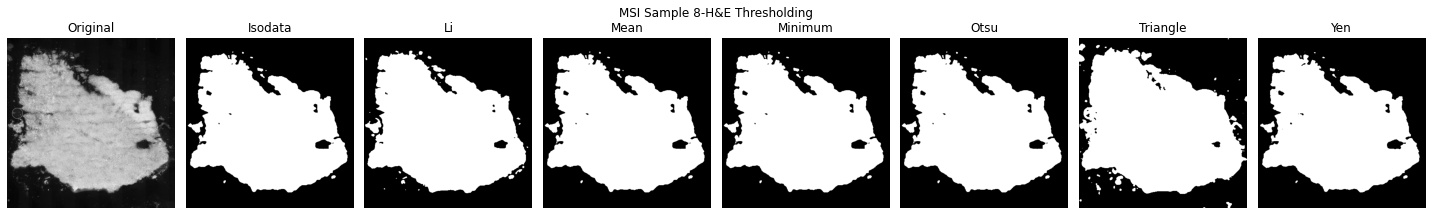

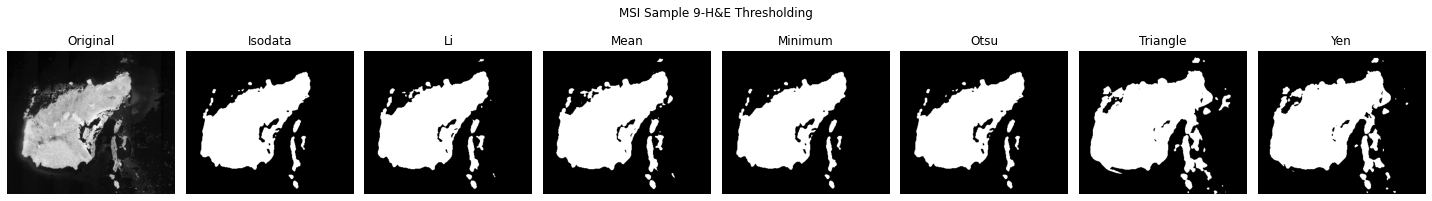

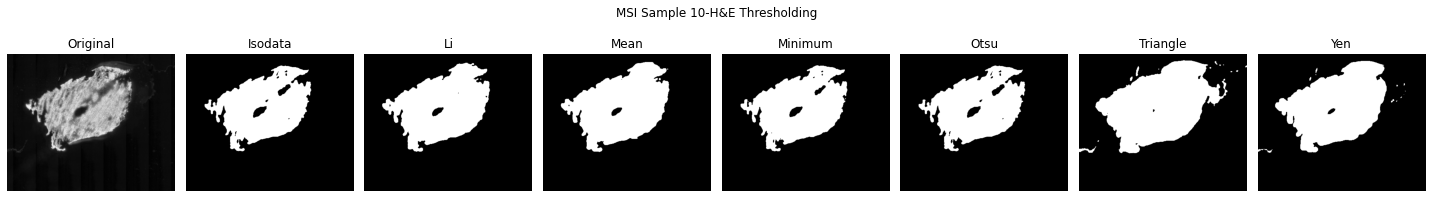

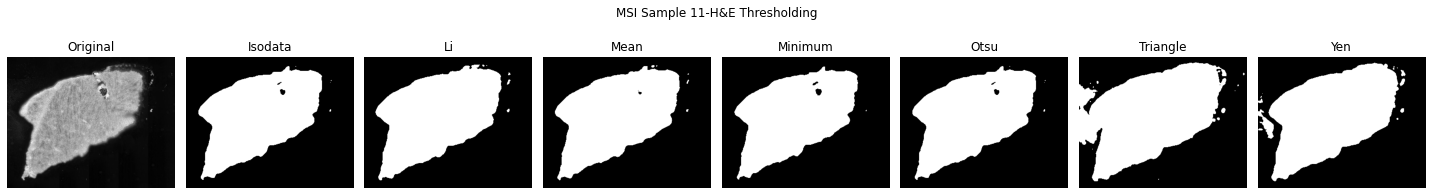

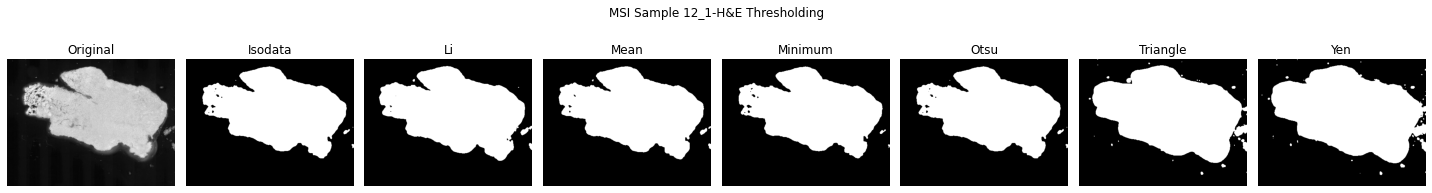

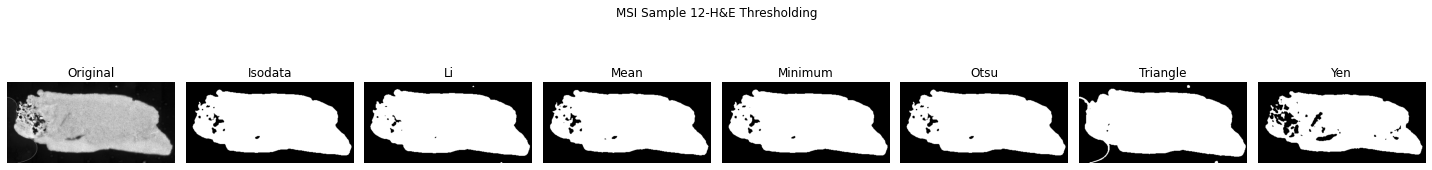

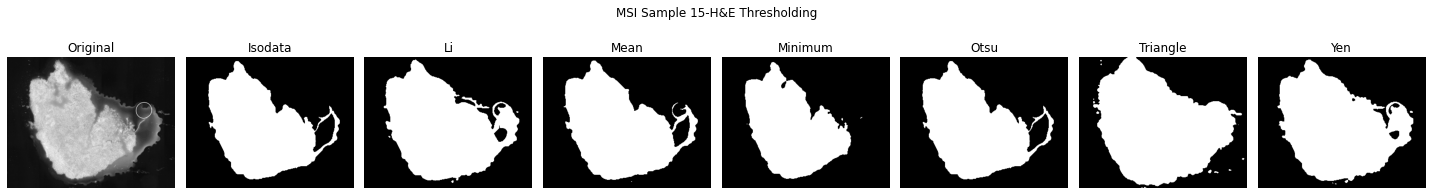

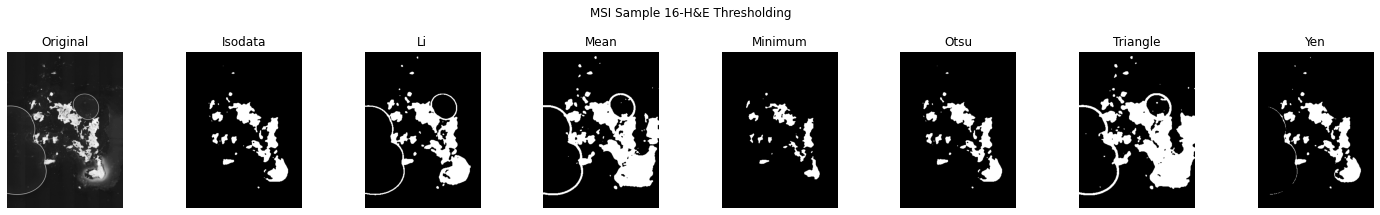

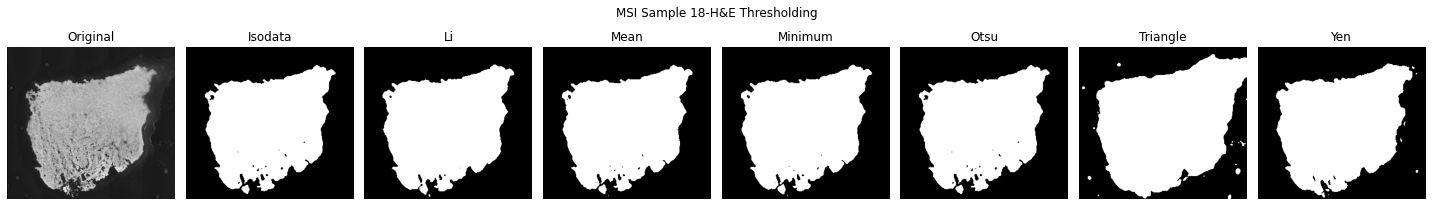

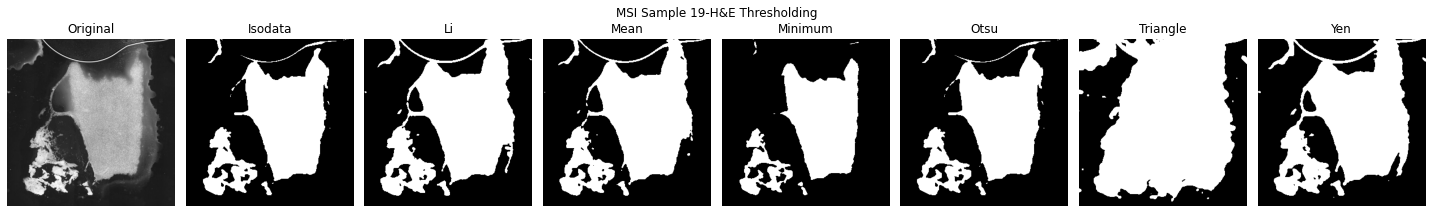

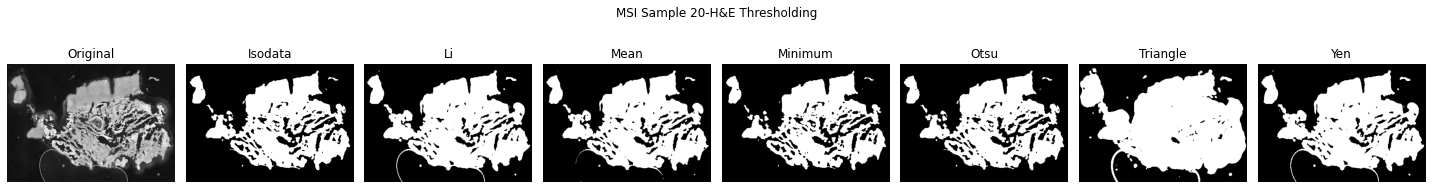

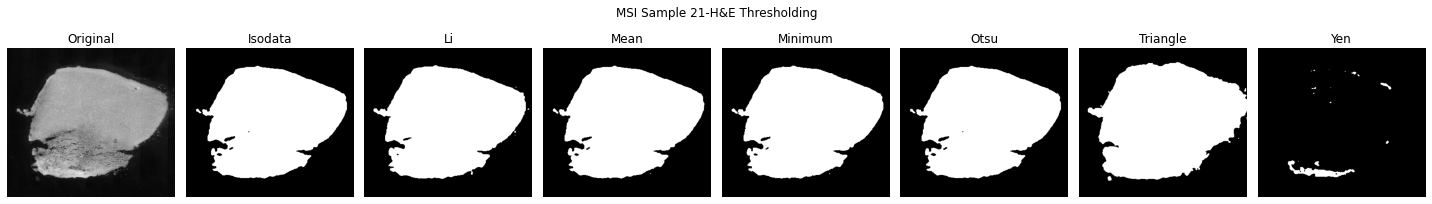

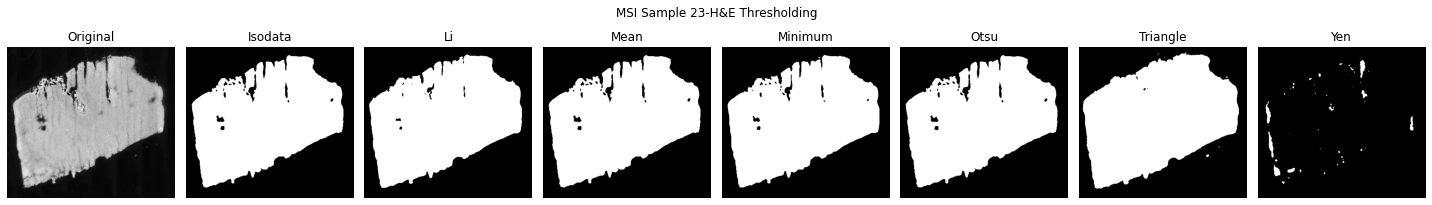

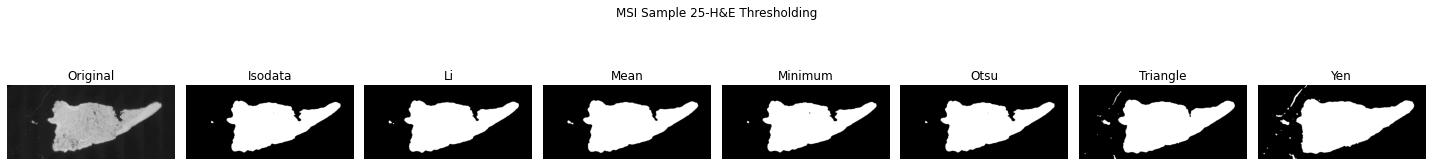

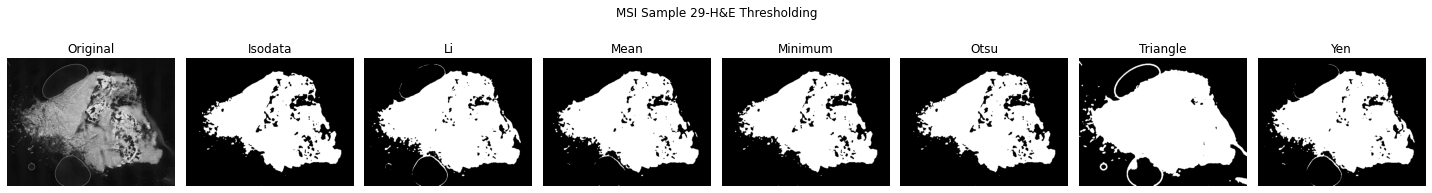

In [12]:
# get all mass spec images names
he_names = np.asarray([f for f in os.listdir(he_data_p) if f.endswith('.png')])

# loop over each mass spec image name and plot mz ion image
for he_name in he_names:
  # read H&E image
  he_img = io.imread(os.path.join(he_data_p, he_name))

  # convert H&E image to grayscale
  he_gray = color.rgb2gray(1 - he_img)
    
  # get all thresholding algorithms outputs
  fig, ax = try_all_threshold(he_gray, figsize=(20, 3), blur=True)

  # plot thresholding algorithms outputs
  fig.suptitle(f"MSI Sample {he_name.split('.')[0]} Thresholding")
  plt.tight_layout()
  plt.show()